# SIMULATED DATASET 

In [1]:
import pandas as pd
import numpy as np
from Bio import SeqIO
import torch
from crossevopred.src.model.dummy_model import DummyModel
from crossevopred.src.model.trainer import Trainer
from crossevopred.utils.data_processing_utils import *
from crossevopred.src.data.dataset import ExpressionDataset
from crossevopred.src.data.encoder import *
import yaml
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
warnings.filterwarnings('ignore')
sns.set_theme(style="ticks")
plt.rcParams['figure.figsize'] = [2, 2]

%load_ext autoreload
%autoreload 2


SyntaxError: invalid syntax (encoder.py, line 155)

## Create simulated dataset

In [ ]:
def window_array(arr, window_size):
    return np.array([np.mean(arr[i:i+window_size]) for i in range(0, len(arr)-window_size+1, window_size)])

def write_bed_file(sequences, scores, output_bed):
    with open(output_bed, "w") as f:
        for i in range(len(sequences)):
            sequence = sequences[i]
            score = scores[i]
            f.write("chr1\t{}\t{}\t{}\t{}\n".format(i, i+len(sequence), ','.join([str(x) for x in score]), sequence))
# Simulate N sequences of length L. Each A +4, C+3, G+2, T+0 . 
# The output is a bed file with chr1 x y fasta_sequence [score_pos1, score_pos2, ...]
# in the simulation I want to have sequences that are very A rich and sequences that are very T rich.
# but still have some C and G.
def simulate_sequences(N, L, window_size, output_bed):
    sequences = []
    for i in range(int(N/2)):
        sequence = np.random.choice(["A", "C", "G", "T"], L, p=[0.5, 0.25, 0.25, 0])
        sequences.append("".join(sequence))
    for i in range(int(N/2)):
        sequence = np.random.choice(["A", "C", "G", "T"], L, p=[0, 0.25, 0.25, 0.5])
        sequences.append("".join(sequence))
    sequences = np.array(sequences)
    # scores are 4 for A, 3 for C, 2 for G, 0 for T
    scores = np.array([[4 if c == "A" else 3 if c == "C" else 2 if c == "G" else 0 for c in sequence] for sequence in sequences])
    scores = np.array([window_array(score, window_size) for score in scores])

    # shuffle sequences and scores but keep them in the same order
    p = np.random.permutation(len(sequences))
    sequences = sequences[p]
    scores = scores[p]
    # write it in 3 different bed files (train, val, test)
    # proportions 80% train, 10% val, 10% test
    train_proportion = 0.8
    val_proportion = 0.1
    test_proportion = 0.1
    train_size = int(N * train_proportion)
    val_size = int(N * val_proportion)
    test_size = int(N * test_proportion)
    train_sequences = sequences[:train_size]
    val_sequences = sequences[train_size:train_size+val_size]
    test_sequences = sequences[train_size+val_size:]
    train_scores = scores[:train_size]
    val_scores = scores[train_size:train_size+val_size]
    test_scores = scores[train_size+val_size:]

    # To each of the datasets, add for 25% of the sequences a motif
    # GAGGAG motif adds 15 to the score
    # Add motif to 25% of the sequences randomly
    motif = "GAGGAGGGGGGAGAG"

    for i in range(int(train_size/4)):
        start = np.random.randint(0, L-6)
        end = start + 6
        train_sequences[i] = train_sequences[i][:start] +  motif+ train_sequences[i][end:]
        train_scores[i][start:end] += 150
    for i in range(int(val_size/4)):
        start = np.random.randint(0, L-6)
        end = start + 6
        val_sequences[i] = val_sequences[i][:start] +  motif+ val_sequences[i][end:]
        val_scores[i][start:end] += 150
    for i in range(int(test_size/4)):
        start = np.random.randint(0, L-6)
        end = start + 6
        test_sequences[i] = test_sequences[i][:start] +  motif+ test_sequences[i][end:]
        test_scores[i][start:end] += 150
    # write bed files
    write_bed_file(train_sequences, train_scores, output_bed + "_train.bed")
    write_bed_file(val_sequences, val_scores, output_bed + "_val.bed")
    write_bed_file(test_sequences, test_scores, output_bed + "_test.bed")

    return output_bed + "_train.bed", output_bed + "_val.bed", output_bed + "_test.bed"

# Create simulated data
training_file = "../simulated/simulated"
config_file = "../bin/crossevopred/config/test_config.yaml"
simulate_sequences(N = 200, L = 1000, window_size= 128, output_bed=training_file)

# Create simulated dataset
training_dataset = ExpressionDataset(training_file+ "_train.bed")
training_dataset_file = training_file+ "_test_dataset.pt"
torch.save(training_dataset, training_dataset_file)

# Create simulated dataset
test_dataset = ExpressionDataset(training_file+ "_test.bed")
test_dataset_file = training_file+ "_test_dataset.pt"
torch.save(test_dataset, test_dataset_file)

# Create simulated dataset
val_dataset = ExpressionDataset(training_file+ "_val.bed")
val_dataset_file = training_file+ "_val_dataset.pt"
torch.save(val_dataset, val_dataset_file)


## Plots for overview of simulated dataset

Text(0, 0.5, 'Percentage of sequences with motif')

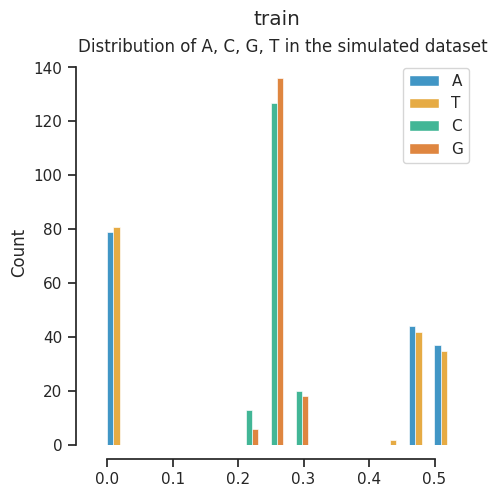

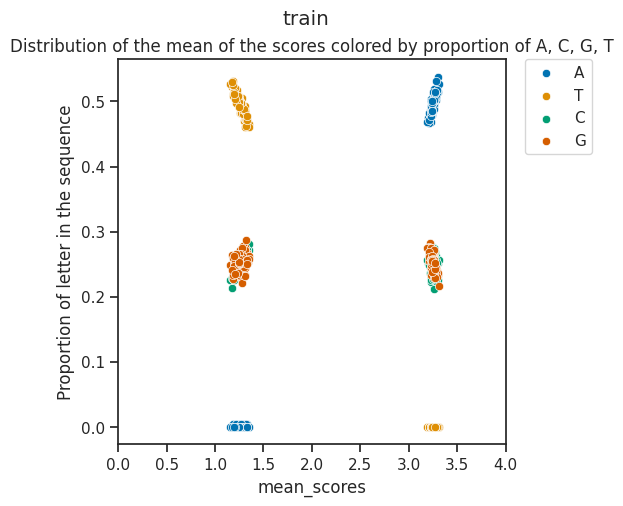

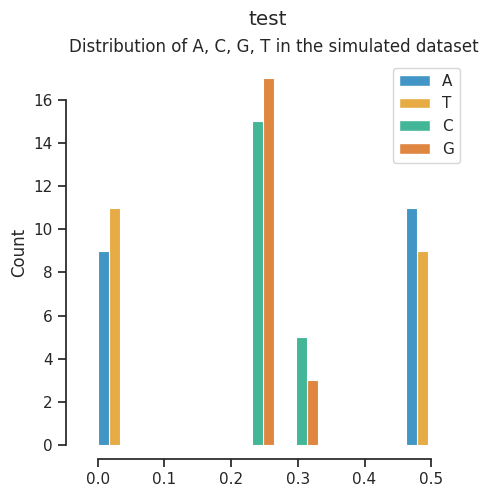

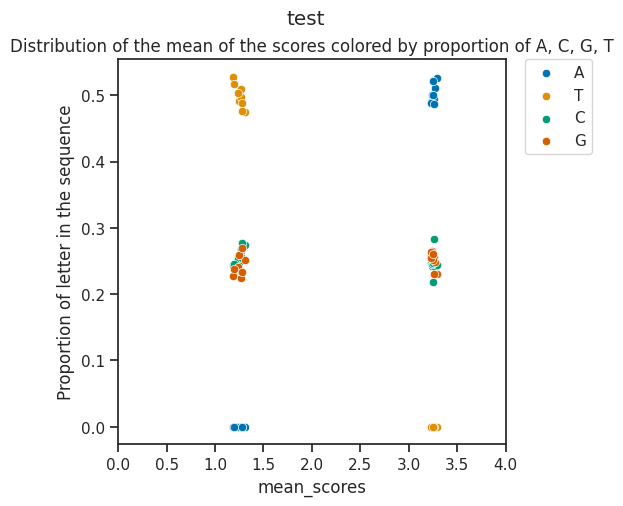

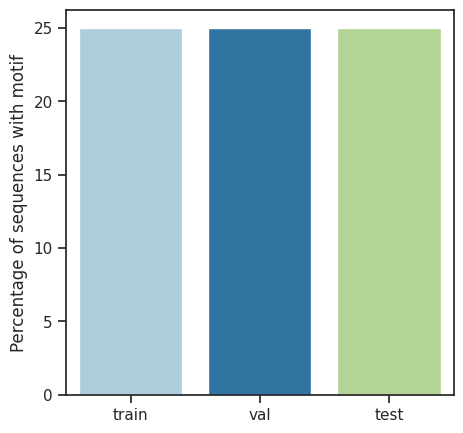

In [6]:

sns.set_palette("colorblind")

# Visualize the dataset distributions of the simulated data
suptitle = "Simulated data"
# calculate A, C, G, T proportions

def prep_df_input_file(file):
    df = pd.read_csv(file, sep="\t", header=None)
    df.columns = ["chr", "start", "end", "scores", "sequence"]
    df["A"] = df["sequence"].apply(lambda x: x.count("A")/len(x))
    df["C"] = df["sequence"].apply(lambda x: x.count("C")/len(x))
    df["G"] = df["sequence"].apply(lambda x: x.count("G")/len(x))
    df["T"] = df["sequence"].apply(lambda x: x.count("T")/len(x))
    df["mean_scores"] = df["scores"].apply(lambda x: np.mean([float(i) for i in x.split(",")]))
    return df

def plot_distribution(df, suptitle = "", title = "Distribution of A, C, G, T in the simulated dataset"):
    plot_1 = plt.figure(figsize=(5, 5))  # Adjust width and height as needed
    plot_1 = sns.histplot(df[["A",  "T", "C", "G"]], multiple = "dodge")
    # add log scale
    plt.title(title)
    sns.despine(offset=10, trim=True)
    plt.suptitle(suptitle)
    return plot_1

def plot_scatter_labels(df, suptitle = "", title = "Scatter plot"):
    plot_2 = plt.figure(figsize=(5, 5))  # Adjust width and height as needed
    plot_2 = sns.scatterplot(data=df, x="mean_scores", y="A", label="A")
    plot_2 = sns.scatterplot(data=df, x="mean_scores", y="T", label="T")
    plot_2 = sns.scatterplot(data=df, x="mean_scores", y="C", label="C")
    plot_2 = sns.scatterplot(data=df, x="mean_scores", y="G", label="G")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel("Proportion of letter in the sequence")
    # x axis start from 0 
    plt.xlim(0, 4)
    plt.title("Distribution of the mean of the scores colored by proportion of A, C, G, T")
    # subtitle
    plt.suptitle(suptitle)
    return plot_2

train_df = prep_df_input_file(training_file+ "_train.bed")
val_df = prep_df_input_file(training_file+ "_val.bed")
test_df = prep_df_input_file(training_file+ "_test.bed")

# train
plot1 = plot_distribution(train_df, "train")
plot2 = plot_scatter_labels(train_df, "train")
# test
plot1 = plot_distribution(test_df, "test")
plot2 = plot_scatter_labels(test_df, "test")

# ----------------------------------------------------
# Motif plot
# ----------------------------------------------------
motif = "GAGGAGGGGGGAGAG"
# Check wich sequences have the GAGGAG motif
train_df[motif] = train_df["sequence"].apply(lambda x: 1 if motif in x else 0)
val_df[motif] = val_df["sequence"].apply(lambda x: 1 if motif in x else 0)
test_df[motif] = test_df["sequence"].apply(lambda x: 1 if motif in x else 0)
# plot percenntage of motif colored by the dataset 
# barplot with the percentage of sequences with the GAGGAG motif and as x the dataset
sns.set_palette("Paired")

plot_3 = plt.figure(figsize=(5, 5))  # Adjust width and height as needed
plot_3 = sns.barplot(x=["train", "val", "test"],
                     y=[train_df[motif].sum()*100/len(train_df), val_df[motif].sum()*100/len(val_df), test_df[motif].sum()*100/len(test_df)])
plot_3.set_ylabel("Percentage of sequences with motif")


## Test training on simulated dataset

In [52]:
# retrain model 
import numpy as np
import torch
from crossevopred.src.model.dummy_model import DummyModel
from crossevopred.src.model.trainer import Trainer
from crossevopred.utils.data_processing_utils import *
from crossevopred.src.data.encoder import *
from crossevopred.utils.plots import *
import torch.nn as nn
# pearsonr
from scipy.stats import pearsonr
from torch.utils.data import Dataset, DataLoader

%load_ext autoreload
%autoreload 2

tune_configuration = "./crossevopred/config/tune_config.yaml"
best_config_file = "./crossevopred/ray_tune/config/best_config.yaml"

# seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)


# Initialize model 
model   = DummyModel()
model.initialize_weights("xavier_uniform_")
# Load the dataset
trainining_datatset_loader = DataLoader(torch.load(training_dataset_file), batch_size = 32, shuffle = True)
val_datatset_loader = DataLoader(torch.load(val_dataset_file), batch_size= 32, shuffle = True)
test_datatset_loader = DataLoader(torch.load(test_dataset_file), batch_size= 32, shuffle = True)   


# Inizialize the trainer
trainer = Trainer(model = model,
                       training_loader = trainining_datatset_loader,
                       validation_loader = val_datatset_loader,
                       test_loader = test_datatset_loader,
                       verbose=True)

# Tune the model
trainer.tune(tune_configuration, best_config_file = best_config_file)

# Train the model
trainer.training_loader = DataLoader(torch.utils.data.ConcatDataset([torch.load(training_dataset_file), torch.load(val_dataset_file)]))
trainer.train( best_config_file )


2024-02-22 09:54:03,697	INFO tune.py:1047 -- Total run time: 5.68 seconds (5.62 seconds for the tuning loop).


 -  Best config saved in ./crossevopred/ray_tune/config/best_config.yaml
 -  Epoch 1/33
 -  Epoch avg loss: 4.844779561460018
 -  Epoch 2/33
 -  Epoch avg loss: 4.651812618970871
 -  Epoch 3/33
 -  Epoch avg loss: 3.792778715491295
 -  Epoch 4/33
 -  Epoch avg loss: 2.3002796702086927
 -  Epoch 5/33
 -  Epoch avg loss: 1.4682779493625275
 -  Epoch 6/33
 -  Epoch avg loss: 1.0777783099096268
 -  Epoch 7/33
 -  Epoch avg loss: 0.6687573720584623
 -  Epoch 8/33
 -  Epoch avg loss: 0.5455121957231313
 -  Epoch 9/33
 -  Epoch avg loss: 0.43333625253289937
 -  Epoch 10/33
 -  Epoch avg loss: 0.3922551163006574
 -  Epoch 11/33
 -  Epoch avg loss: 0.40088344463147224
 -  Epoch 12/33
 -  Epoch avg loss: 0.396019771695137
 -  Epoch 13/33
 -  Epoch avg loss: 0.3399668548256159
 -  Epoch 14/33
 -  Epoch avg loss: 0.3480164703913033
 -  Epoch 15/33
 -  Epoch avg loss: 0.3722613202407956
 -  Epoch 16/33
 -  Epoch avg loss: 0.377245110925287
 -  Epoch 17/33
 -  Epoch avg loss: 0.3600452252663672
 -  

In [53]:
trainer._evaluate_loss(test_datatset_loader,"PoissonNLLLoss")

0.21634261310100555

<Axes: title={'center': 'Loss vs epoch'}, xlabel='epoch', ylabel='loss'>

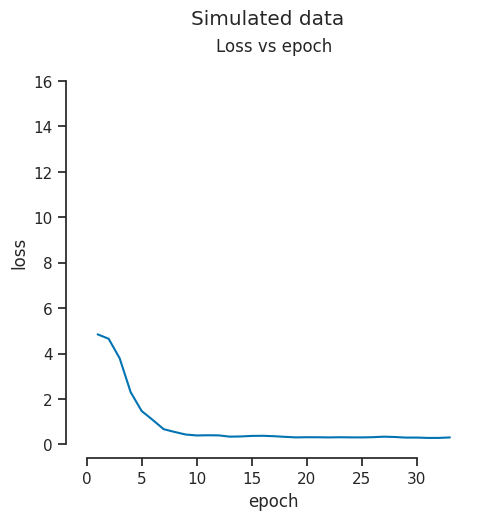

In [54]:
# Plots 
sns.set_palette("colorblind")
plot_loss_vs_epoch(trainer.training_infos, "Simulated data", "Loss vs epoch")